In [1]:
%pylab inline
# %load_ext memory_profiler

import os
import time
import warnings

import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
import pygraphviz
from pomegranate import BayesianNetwork
from pomegranate.utils import plot_networkx
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf

os.chdir('../')
from src.features.build_features import (
    daily_return, uniform_clustering, create_shifted_rt, downloading_stocks_data, return_in_period, binary_clustering)
os.chdir('./notebooks')

warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


# Aquisição dos dados

Segundo o artigo, eles usaram dados do índice Nikkey (**^N225**) e o da ação da Toyota (**7203.T**), entre 22/02/1985 e 30/12/2008.

In [2]:
df_nikkey = yf.download("^N225", start="1984-10-01", end="2008-12-30")

[*********************100%***********************]  1 of 1 completed


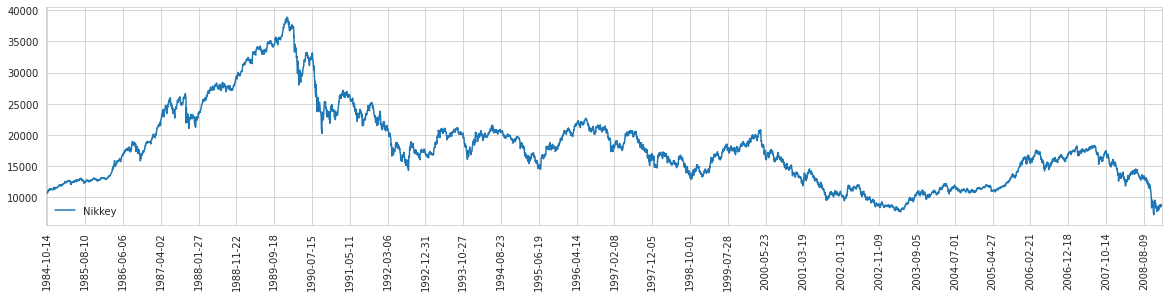

In [3]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_nikkey['Close'], label="Nikkey")

date_min = df_nikkey.index.min()
date_max = df_nikkey.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

### IMPORTANTE!

Continuar somente com o Índice Nikkey 225, por enquanto. Pois não temos somente os dados da Toyota a partir de 1999.


## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (22/02/1985 até 30/11/2008) e de validação do modelo (01/12/2008 até 30/12/2008).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [6]:
df = df_nikkey[["Close"]].copy()
df = daily_return(df)
df = create_shifted_rt(df, [1,5,7])
df = uniform_clustering(df)
df = df[[column for column in df.columns if 'cluster_' in column]].copy()
df.dropna(how='any', axis=0, inplace=True)

df.head()

,cluster_Close,cluster_Close-1,cluster_Close-5,cluster_Close-7
Date,,,,
1984-10-12,3.0,4.0,5.0,2.0
1984-10-15,5.0,3.0,5.0,5.0
1984-10-16,3.0,5.0,2.0,5.0
1984-10-17,3.0,3.0,3.0,5.0
1984-10-18,4.0,3.0,4.0,2.0


In [9]:
X_train = df[:"2008-11-30"]
X_test = df["2008-12-01":]

print(f"""Base original: {df_nikkey.shape}
X_train: {X_train.shape}
X_test: {X_test.shape}\n""")

X_train.head()

Base original: (5976, 6)
X_train: (5948, 4)
X_test: (20, 4)



,cluster_Close,cluster_Close-1,cluster_Close-5,cluster_Close-7
Date,,,,
1984-10-12,3.0,4.0,5.0,2.0
1984-10-15,5.0,3.0,5.0,5.0
1984-10-16,3.0,5.0,2.0,5.0
1984-10-17,3.0,3.0,3.0,5.0
1984-10-18,4.0,3.0,4.0,2.0


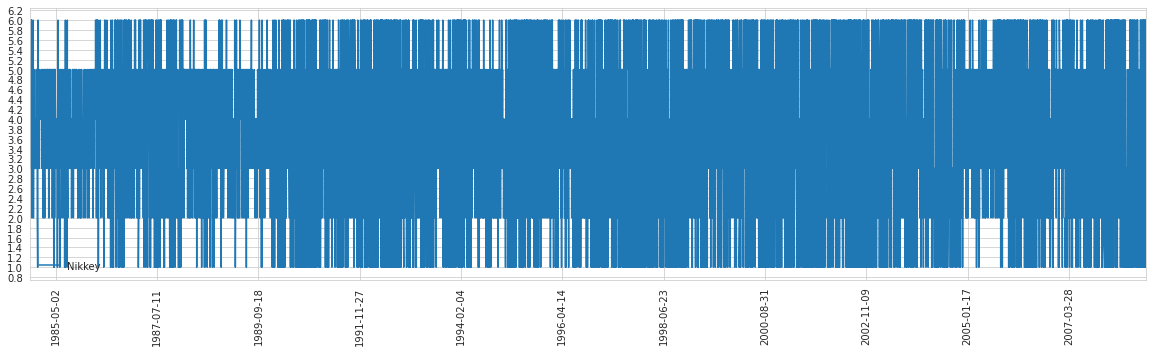

In [11]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = X_train.index.min()
date_max = X_train.index.max()

ax.plot(X_train['cluster_Close'], label="Nikkey")

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
# ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

### Agrupamento dos $r_{t}$

**Agrupamentos uniformes**

Comparando agrupamento abtido com o agrupamento exposto no artigo.


![2012_zuo_table_01_uniform_clustering](../reports/figures/2012_zuo_table_01_uniform_clustering.png)

### Adição de atributos conforme a rede bayesiana obtida

De acordo com os autores, usando o algoritmo K2, eles obtiveram a seguinte rede bayesiana:

``` dot

digraph G{
    rt-1 -> rt
    rt-5 -> rt
    rt-37 -> rt
}

```


Portanto, serão adicionados os seguintes atributos: **rt-1**, **rt-5** e **rt-37**, sendo que o número indica a quantidade de dias atrás que é necessário.

## Achando a estrutura da rede

In [14]:
X_train.head()

,cluster_Close,cluster_Close-1,cluster_Close-5,cluster_Close-7
Date,,,,
1984-10-12,3.0,4.0,5.0,2.0
1984-10-15,5.0,3.0,5.0,5.0
1984-10-16,3.0,5.0,2.0,5.0
1984-10-17,3.0,3.0,3.0,5.0
1984-10-18,4.0,3.0,4.0,2.0


In [20]:
lst_cluster = [column for column in df.columns if 'cluster_' in column]
lst_cluster

['cluster_Close', 'cluster_Close-1', 'cluster_Close-5', 'cluster_Close-7']

In [22]:
X_train.head()

,cluster_Close,cluster_Close-1,cluster_Close-5,cluster_Close-7
Date,,,,
1984-10-12,3.0,4.0,5.0,2.0
1984-10-15,5.0,3.0,5.0,5.0
1984-10-16,3.0,5.0,2.0,5.0
1984-10-17,3.0,3.0,3.0,5.0
1984-10-18,4.0,3.0,4.0,2.0


Constraint Graph


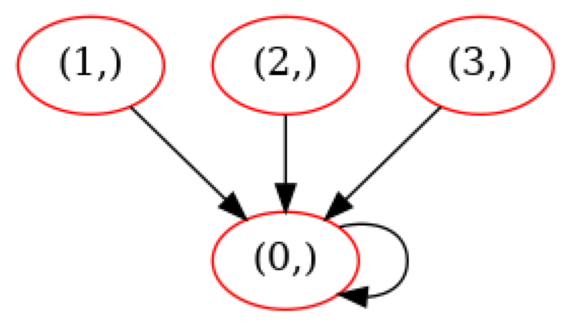

In [34]:
a = networkx.DiGraph()
b = lst_cluster.copy()
# b.remove('cluster_Close')

for i, item in enumerate(b):
    a.add_edge(tuple([i]), tuple([X_train.columns.get_loc('cluster_Close')]))

print("Constraint Graph")
plt.figure(figsize=(10, 8))
plot_networkx(a)
plt.show()

Constraint Graph


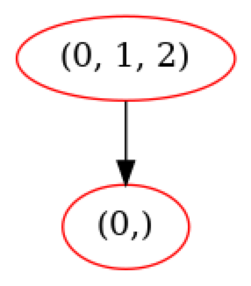

In [30]:
a = networkx.DiGraph()
b = lst_cluster.copy()
b.remove('cluster_Close')

a.add_edge(tuple(np.arange(len(X_train.columns[1:]))), tuple([X_train.columns.get_loc('cluster_Close')]))

print("Constraint Graph")
plt.figure(figsize=(5, 5))
plot_networkx(a)
plt.show()

In [38]:
X_train.head()

,cluster_Close,cluster_Close-1,cluster_Close-5,cluster_Close-7
Date,,,,
1984-10-12,3.0,4.0,5.0,2.0
1984-10-15,5.0,3.0,5.0,5.0
1984-10-16,3.0,5.0,2.0,5.0
1984-10-17,3.0,3.0,3.0,5.0
1984-10-18,4.0,3.0,4.0,2.0


((), (), (), ())
((), (), (3,), ())


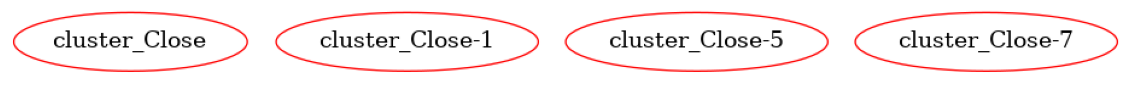

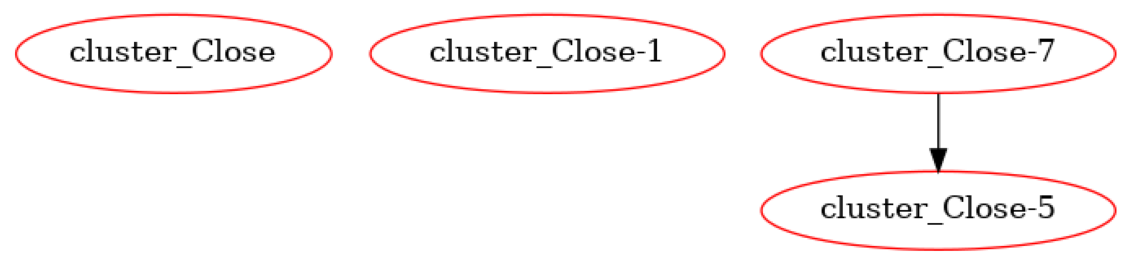

In [37]:
for algorith in ["exact", "greedy"]:
    model = BayesianNetwork.from_samples(
        X_train[lst_cluster], algorithm=algorith, state_names=lst_cluster, constraint_graph=a
        , reduce_dataset=False, n_jobs=-1
        )
    print(model.structure)
    plt.figure(figsize=(20, 5))
    model.plot()

## Aplicando a mesma lógica aplicada no notebook do ARIMA

In [62]:
ntest = 20
ntotal = df.shape[0]
X_predict = []

for cont in np.arange(ntest):
    X_train = df[:-ntest+cont]
    X_test = df[-ntest+cont:ntotal-ntest+1+cont]
    X_test.iloc[:, 0] = None

    model = BayesianNetwork.from_samples(
        X_train[lst_cluster], algorithm=algorith, state_names=lst_cluster, constraint_graph=a, reduce_dataset=False, n_jobs=-1
        )
    model.bake()

    X_predict.append(model.predict(X_test.to_numpy()))

In [63]:
pd.DataFrame(X_predict)

,0
0,"[5.0, 6.0, 6.0, 2.0]"
1,"[5.0, 1.0, 6.0, 1.0]"
2,"[5.0, 1.0, 1.0, 6.0]"
3,"[5.0, 6.0, 6.0, 6.0]"
4,"[5.0, 2.0, 6.0, 1.0]"
5,"[5.0, 3.0, 1.0, 6.0]"
6,"[5.0, 6.0, 1.0, 6.0]"
7,"[5.0, 5.0, 6.0, 1.0]"
8,"[5.0, 6.0, 2.0, 1.0]"
9,"[5.0, 5.0, 3.0, 6.0]"
